# Bayesian UQ-SINDy

In [1]:
from jax import config
config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(2)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import pysindy as ps
import arviz as az

In [3]:
# set seed for reproducibility
np.random.seed(123)

## Harmonic oscillator

In [4]:
# set up a class that defines a harmonic oscillator
class HarmonicOscillator:
    def __init__(self, zeta=0.1, omega0=2*np.pi, f=None):
        # internalise the model parameters.
        self.zeta = zeta
        self.omega0 = omega0
        if f is None:
            self.f = lambda t: 0
        else:
            self.f = f

    def dydx(self, t, y):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations.}
        return np.array([y[1],
                         -2*self.zeta*self.omega0*y[1] - self.omega0**2*y[0] + self.f(t)])

    def solve(self, **kwargs):
        # solve the system of ODEs.
        return solve_ivp(self.dydx, **kwargs)

In [5]:
# set some hyperparameters.
t_span = [0, 5]
t_eval = np.linspace(*t_span, 50)
y0 = np.array([1,0])

# initialise the model and solve.
f = lambda t: 2*np.sin(2*np.pi*t)
my_model = HarmonicOscillator(f=f)
sol = my_model.solve(t_span=t_span, y0=y0, t_eval=t_eval)

In [6]:
# the noise level.
noise = 0.3

# extract the timesteps and perturb the solution with noise.
t = sol.t
x = sol.y[0,:] + 0.2*np.random.normal(scale=noise, size=sol.t.size)
v = sol.y[1,:] + np.random.normal(scale=noise, size=sol.t.size)

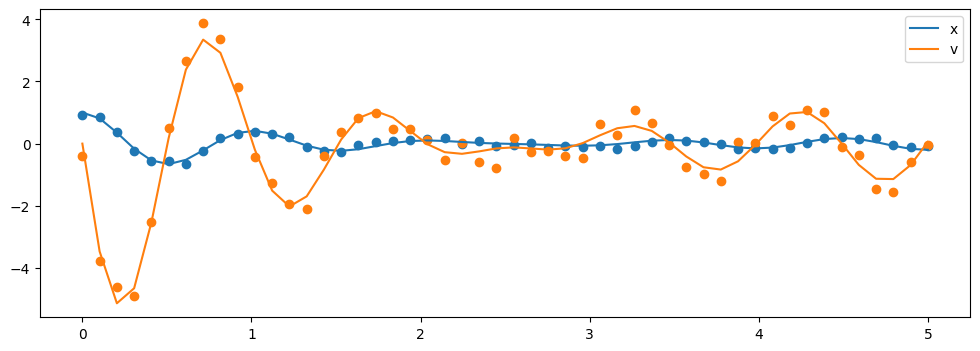

In [7]:
# plot the solution.
plt.figure(figsize=(12,4))
plt.plot(sol.t, sol.y[0,:], label = "x")
plt.scatter(t, x)
plt.plot(sol.t, sol.y[1,:], label="v")
plt.scatter(t, v)
plt.legend()
plt.show()

## Bayesian UQ-SINDy

Here we recover the governing equations using UQ-SINDy. For more details on the theory of the method, see Hirsh, S. M., Barajas-Solano, D. A., & Kutz, J. N. (2021). *Sparsifying Priors for Bayesian Uncertainty Quantification in Model Discovery* (arXiv:2107.02107). arXiv. http://arxiv.org/abs/2107.02107

The underlying code used to find the posterior distribution of model parameters is `numpyro.infer.MCMC` using the `numpyro.infer.NUTS` kernel. Note that all keyword arguments passed to `pysindy.optimizers.SBR` are sent forward to the [MCMC sampler](https://num.pyro.ai/en/stable/mcmc.html).

In [8]:
# set sampler hyperparameters
sampling_seed = 987

if __name__ == "testing":
    num_warmup = 10
    num_samples = 100
    num_chains = 1
else:
    num_warmup = 1000
    num_samples = 10000
    num_chains = 2

### Use the approximate (fast) method.

In [9]:
# initialise the approximate Sparse Bayesian Regression optimizer.
approximate_optimizer = ps.optimizers.SBR(num_warmup=num_warmup,
                                          num_samples=num_samples,
                                          mcmc_kwargs={"seed": sampling_seed,
                                                       "num_chains": num_chains},
                                          exact=False)

# use the standard polynomial features.
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True)

# initialise SINDy and fit to the data.
approximate_sindy = ps.SINDy(approximate_optimizer, feature_library, feature_names=['x', 'v', 'f'])
approximate_sindy.fit(np.c_[x, v], t=t, u=f(t))

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x', 'v', 'f'],
      optimizer=SBR(exact=False, integrator_kwargs={},
                    mcmc_kwargs={'num_chains': 2, 'seed': 987},
                    num_samples=10000))

In [10]:
# set up a new differential equation that uses the Bayesian SINDy predictions.
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return approximate_sindy.predict(x=_y,u=f(t))

# solve using the Bayesian SINDy equations.
surrogate_sol = solve_ivp(surrogate_dydt, t_span=t_span, y0=y0, t_eval=t_eval)

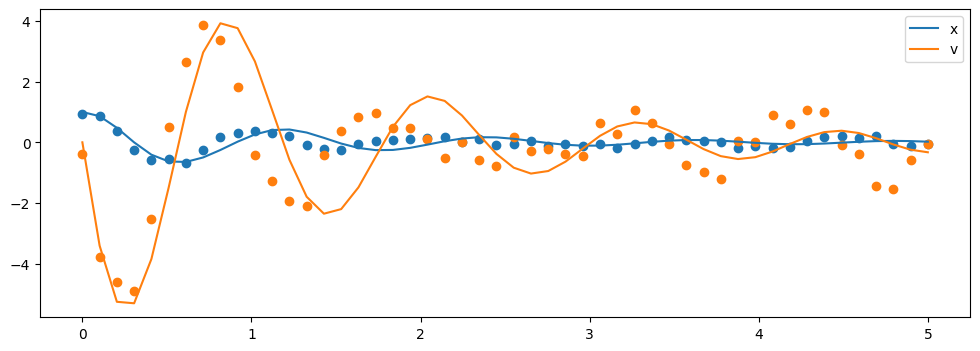

In [11]:
# plot the surrogate solution.
plt.figure(figsize=(12,4))

plt.plot(surrogate_sol.t, surrogate_sol.y[0,:], label = "x")
plt.scatter(t, x)

plt.plot(surrogate_sol.t, surrogate_sol.y[1,:], label="v")
plt.scatter(t, v)

plt.legend()
plt.show()

### Get MCMC diagnostics from the approximate method

We can inspect the posterior samples in more detail using `arviz`. Note that this is not included as a dependency of `pysindy` and must be installed separately.

In [12]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(approximate_optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.016,0.179,-0.367,0.391,0.004,0.003,2192.0,1956.0,1.00
"beta[0, 1]",0.054,0.400,-0.658,0.898,0.010,0.007,2148.0,1361.0,1.00
"beta[0, 2]",0.755,0.260,0.282,1.259,0.006,0.005,1757.0,1801.0,1.00
"beta[0, 3]",-0.017,0.136,-0.286,0.271,0.004,0.003,1409.0,482.0,1.00
"beta[0, 4]",0.062,0.481,-0.656,1.072,0.011,0.009,3176.0,1956.0,1.00
"beta[0, 5]",0.006,0.205,-0.389,0.435,0.003,0.002,2532.0,4139.0,1.00
"beta[0, 6]",-0.008,0.355,-0.661,0.665,0.006,0.005,2422.0,3486.0,1.00
"beta[0, 7]",-0.015,0.063,-0.142,0.108,0.001,0.001,1619.0,2724.0,1.00
"beta[0, 8]",0.014,0.107,-0.190,0.236,0.003,0.002,1130.0,4261.0,1.00
"beta[0, 9]",0.000,0.097,-0.211,0.187,0.002,0.001,2768.0,5374.0,1.00


[]

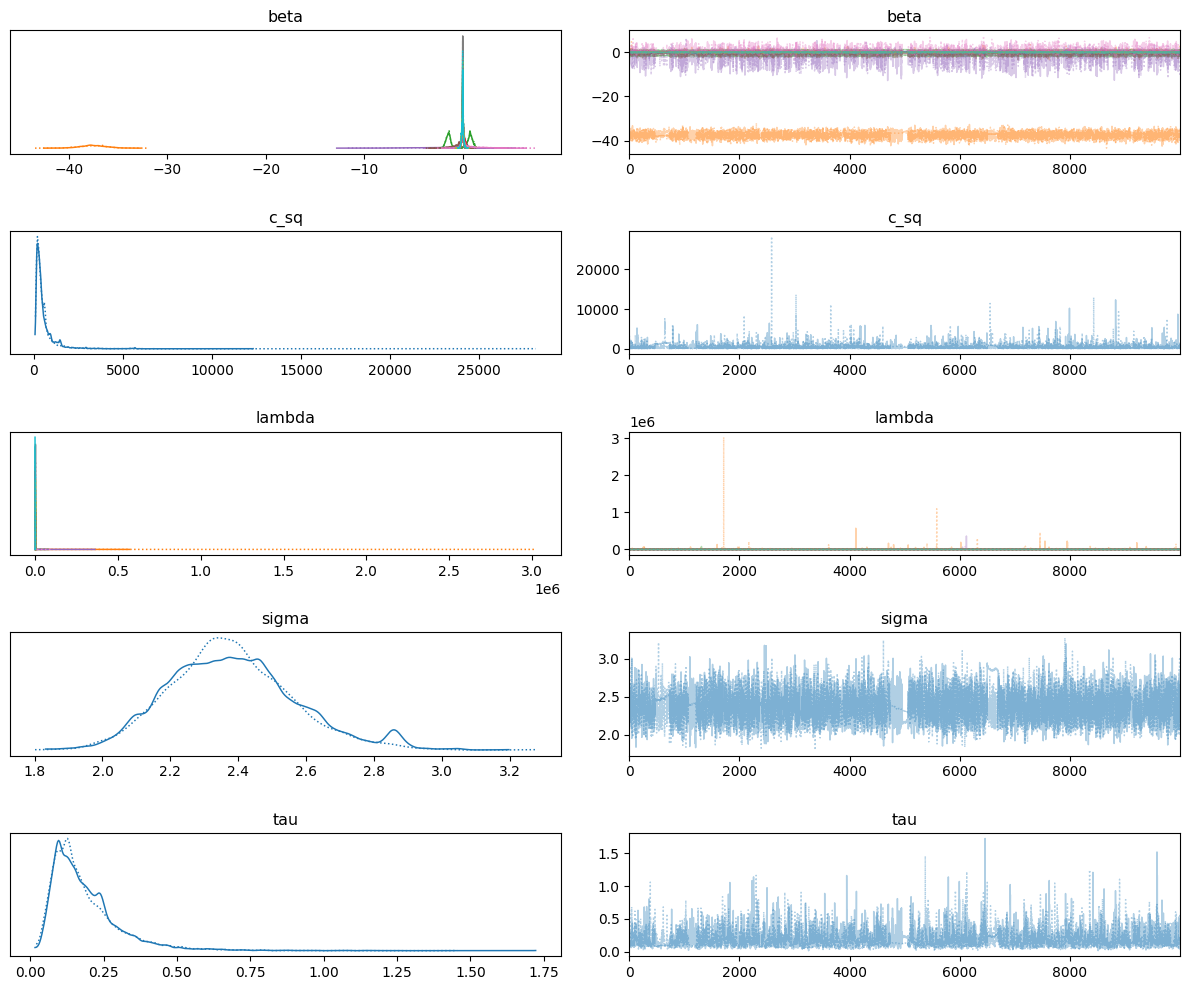

In [13]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()

In [14]:
posterior_mean = {key: value.mean(axis=0) for key, value in approximate_optimizer.mcmc_.get_samples().items()}

### Use the exact method.

In [15]:
# initialise the Sparse bayesian Regression optimizer.
optimizer = ps.optimizers.SBR(num_warmup=num_warmup,
                              num_samples=num_samples,
                              mcmc_kwargs={"seed": sampling_seed,
                                           "num_chains": num_chains,
                                           "initial_values": posterior_mean},
                              integrator_kwargs={"dt": 0.1},
                              )

# use the standard polynomial features.
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True)

# initialise SINDy and fit to the data.
sindy = ps.SINDy(optimizer, feature_library, feature_names=['x', 'v', 'f'])
sindy.fit(np.c_[x, v], t=t, u=f(t))

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x', 'v', 'f'],
      optimizer=SBR(integrator_kwargs={'dt': 0.1},
                    mcmc_kwargs={'initial_values': {'beta': Array([[ 1.61336652e-02,  5.39072056e-02,  7.55010419e-01,
        -1.69825088e-02,  6.15674317e-02,  6.19239446e-03,
        -7.76333337e-03, -1.49587982e-02,  1.41507489e-02,
         3.50778894e...
        2.43367907e+00, 1.53508564e+00, 1.97726163e+00, 9.40690514e-01,
        1.04445330e+00, 1.09861646e+00],
       [1.49052964e+00, 1.76294286e+03, 3.34981916e+01, 1.47248454e+00,
        3.83628807e+01, 3.89150827e+00, 1.72729756e+01, 9.91540799e-01,
        1.09088562e+00, 1.12851740e+00]], dtype=float64),
                                                    'sigma': Array(2.38148131, dtype=float64),
                                                    'tau': Array(0.18457354, dtype=float64)},
                                 'num_chains': 2, 'seed': 987},
                    num_samples=10000))

In [16]:
# set up a new differential equation that uses the Bayesian SINDy predictions.
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return sindy.predict(x=_y, u=f(t))

# solve using the Bayesian SINDy equations.
surrogate_sol = solve_ivp(surrogate_dydt, t_span=t_span, y0=y0, t_eval=t_eval)

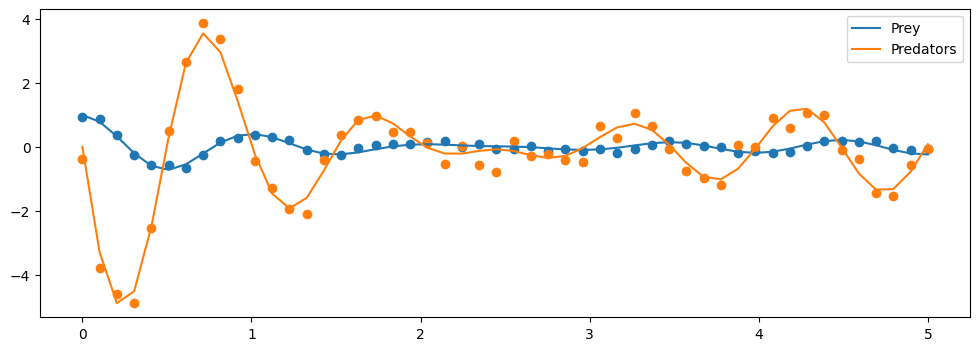

In [17]:
# plot the surrogate solution.
plt.figure(figsize=(12,4))

plt.plot(surrogate_sol.t, surrogate_sol.y[0,:], label = "Prey")
plt.scatter(t, x)

plt.plot(surrogate_sol.t, surrogate_sol.y[1,:], label="Predators")
plt.scatter(t, v)

plt.legend()
plt.show()

### Get MCMC diagnostics from the exact method

In [18]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(sindy.optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.024,0.076,-0.115,0.183,0.001,0.001,3587.0,3115.0,1.0
"beta[0, 1]",-0.148,0.389,-1.253,0.311,0.012,0.009,1614.0,1401.0,1.0
"beta[0, 2]",1.027,0.103,0.837,1.224,0.002,0.001,2985.0,3767.0,1.0
"beta[0, 3]",0.006,0.013,-0.017,0.036,0.000,0.000,1925.0,1553.0,1.0
"beta[0, 4]",-0.258,0.509,-1.479,0.348,0.011,0.008,2781.0,3536.0,1.0
"beta[0, 5]",-0.036,0.168,-0.413,0.280,0.003,0.002,4005.0,3844.0,1.0
"beta[0, 6]",0.093,0.282,-0.379,0.694,0.005,0.004,4427.0,3406.0,1.0
"beta[0, 7]",-0.001,0.017,-0.036,0.031,0.000,0.000,2876.0,4911.0,1.0
"beta[0, 8]",0.012,0.026,-0.036,0.064,0.000,0.000,4770.0,5938.0,1.0
"beta[0, 9]",-0.014,0.040,-0.098,0.054,0.001,0.001,3629.0,3242.0,1.0


[]

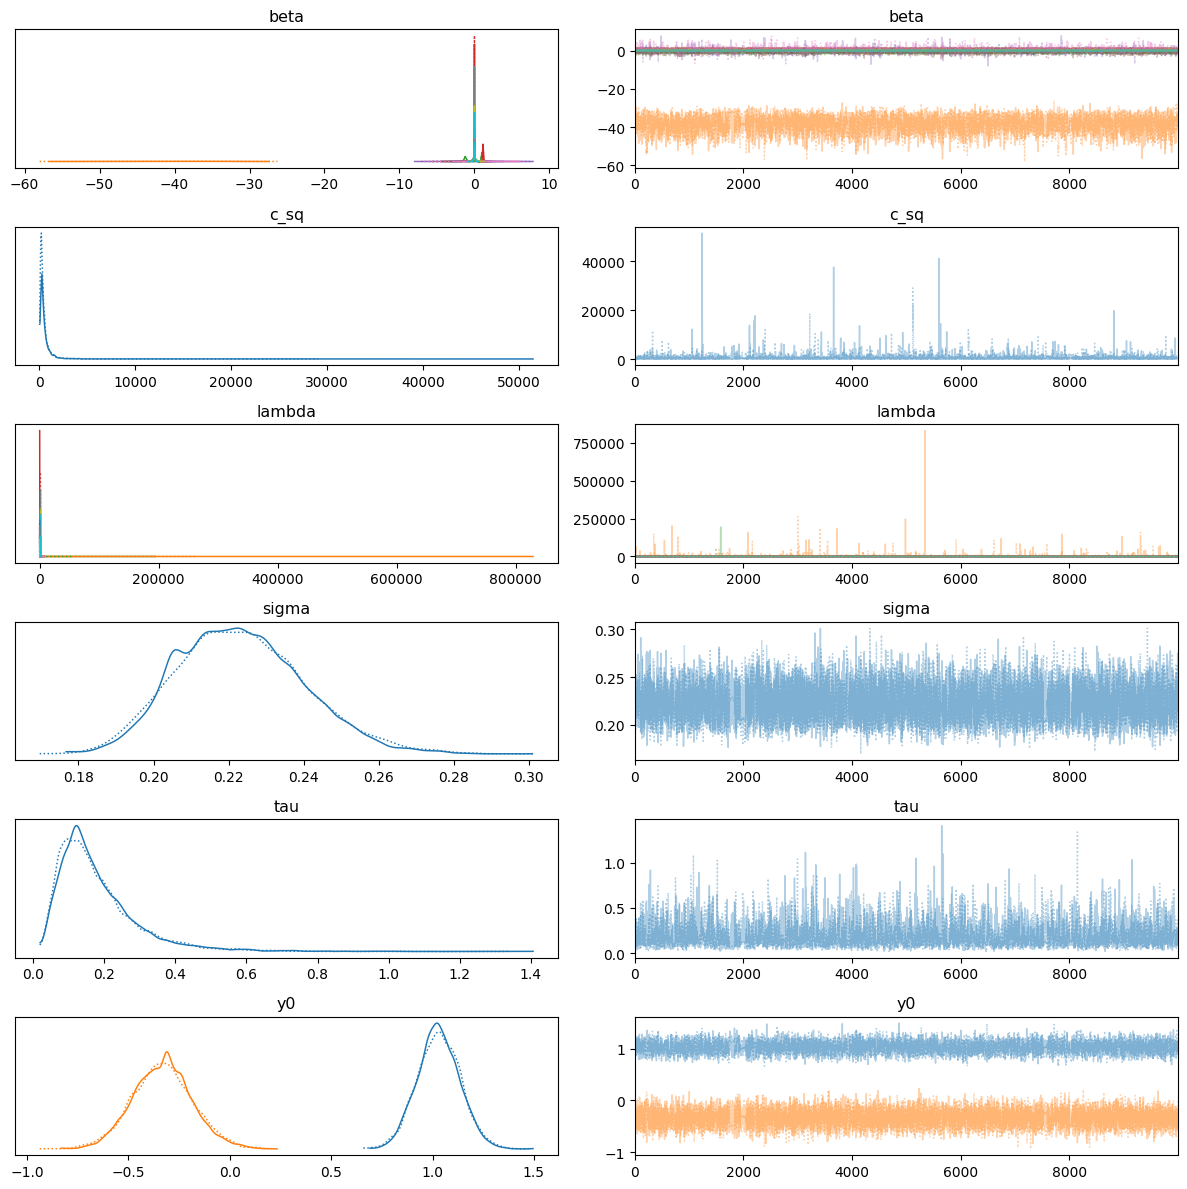

In [19]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()